# New LoVoCCS Relations in Fixed Apertures: $L_{\rm{X}}$-$T_{\rm{X}}$

This section of the project fits scaling relations to properties measured from the X-ray (and other wavelengths) analysis of the LoVoCCS sample of galaxy clusters (introduced by [Fu et al. 2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...933...84F/abstract)). 

This particular part of the scaling relation fitting section of the project uses properties measured within **fixed circular apertures**, rather than within a _scale radius_ that is related to the physical size of the cluster. This can be useful for comparison to some other surveys that measured relations within fixed apertures.

Here we focus on scaling relations between the X-ray luminosity of the hot intra-cluster medium (ICM) of our galaxy clusters ($L_{\rm{X}}$, or $L^{0.5-2.0}_{\rm{X}, R_{ap}kpc}$ within $R_{\rm{ap}}$ in kpc, and 0.5-2.0 keV energy bounds), and the temperature of hot ICM of our clusters ($T_{\rm{X}}$, or $T_{\rm{X, R_{ap}kpc}}$ within $R_{\rm{ap]}}$ in kpc). When we refer to the bolometric (with shorthand 'bol') we are talking about the entire energy range of the telescope.

Relation fits are performed using the XGA interface to the R scaling-relation fitting package LIRA, see the paper for full details.

## Main takeaways

In summary:

* <span style="color:teal">We have constructed...</span>

* <span style="color:teal">They show...</span>

## Import Statements

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '../..')
from common import lovoccs_cosmo, lx_norm, tx_norm

import xga
from xga.relations.fit import scaling_relation_lira

## Output paths

Paths to save the scaling relation objects and visualisations - defined here to avoid repetition and make the code easier to read:

In [2]:
sr_path = "../../../outputs/scaling_relations/lovoccs_new/lx-tx/fixed_aperture/"
vis_path = "../../../outputs/figures/scaling_relations/lovoccs_new/lx-tx/fixed_aperture/"

## Normalisation values

These are used when fitting the scaling relations to normalise the data, and are kept the same throughout this entire project:

In [3]:
lx_norm

<Quantity 1.e+44 erg / s>

In [4]:
tx_norm

<Quantity 4. keV>

## Cosmological model

We use the same cosmology as was utilised in the initial paper of this series:

In [5]:
lovoccs_cosmo

LambdaCDM(name=None, H0=<Quantity 71. km / (Mpc s)>, Om0=0.2648, Ode0=0.7352, Tcmb0=<Quantity 0. K>, Neff=3.04, m_nu=None, Ob0=0.0448)

## Loading data files

Important considerations for this dataset:

* The Local Volume Complete Cluster Survey (LoVoCCS) sample was assembled and first presented by [Fu et al. 2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...933...84F/abstract), with the principle goal of measuring 2D weak-lensing mass maps for all 147 galaxy clusters in the sample.

* The sample aims to be complete within its selection criteria -- $0.03<z<0.12$ - **ROSAT All-Sky Survey (RASS)** $L^{0.1-2.4\rm{keV}}_{\rm{X,500}}>10^{44}\:\rm{erg}\:\rm{s}^{-1}$ - positional cuts to exclude the plane -- and as such be an ideal low-redshift test bed for the measurement of intrinsic scatter between galaxy cluster properties, and a gold standard for future studies.

* LoVoCCS is an *X-ray selected* sample, from the Meta Catalogue of X-ray Detected Clusters of Galaxies (MCXC; [Piffaretti et al. 2011](https://ui.adsabs.harvard.edu/abs/2011A%26A...534A.109P/abstract)) - selecting on $L_{\rm{X}}$ is similar to selecting on mass, but clusters near the $L_{\rm{X}}$ boundary may be scattered in or out of the sample.

* Our first X-ray analysis covers the galaxy clusters included in the first LoVoCCS weak-lensing map release ([Fu et al. 2024](https://ui.adsabs.harvard.edu/abs/2024ApJ...974...69F/abstract)) - 58 systems from the originally selected sample, though we find that in reality some of them are multiple distinct X-ray sources.

### X-LoVoCCS-I base sample

In [6]:
xlovoccs_base = pd.read_csv("../../../sample_files/X-LoVoCCSI.csv")
xlovoccs_base.insert(0, 'name', xlovoccs_base['LoVoCCSID'].apply(lambda x: "LoVoCCS-" + str(x)))
xlovoccs_base.head(6)

,name,LoVoCCSID,common_name,start_ra,start_dec,MCXC_Redshift,MCXC_R500,MCXC_RA,MCXC_DEC,manual_xray_ra,manual_xray_dec,MCXC_Lx500_0.1_2.4
0,LoVoCCS-1,1,A2029,227.734300,5.745471,0.0766,1.3344,227.73000,5.720000,227.734300,5.745471,8.726709e+44
1,LoVoCCS-2,2,A401,44.740000,13.580000,0.0739,1.2421,44.74000,13.580000,NaN,NaN,6.088643e+44
2,LoVoCCS-4A,4A,A85North,10.458750,-9.301944,0.0555,1.2103,10.45875,-9.301944,NaN,NaN,5.100085e+44
3,LoVoCCS-4B,4B,A85South,10.451487,-9.460007,0.0555,1.2103,10.45875,-9.301944,10.451487,-9.460007,5.100085e+44
4,LoVoCCS-5,5,A3667,303.157313,-56.845978,0.0556,1.1990,303.13000,-56.830000,303.157313,-56.845978,4.871933e+44
5,LoVoCCS-7,7,A3827,330.480000,-59.950000,0.0980,1.1367,330.48000,-59.950000,NaN,NaN,4.204419e+44


Calculating E(z) values for these clusters:

In [7]:
xlovoccs_base['E'] = lovoccs_cosmo.efunc(xlovoccs_base['MCXC_Redshift'].values)

### X-LoVoCCS-I $T_{\rm{X}}$ and $L_{\rm{X}}$ (Fixed Apertures)

In [8]:
xlovoccs_txlx = pd.read_csv("../../../outputs/results/fixed_aperture_apec.csv")
xlovoccs_txlx.head(6)

,name,Tx_300kpc,Tx_300kpc-,Tx_300kpc+,met_300kpc,met_300kpc-,met_300kpc+,Lx52_300kpc,Lx52_300kpc-,Lx52_300kpc+,Lxbol_300kpc,Lxbol_300kpc-,Lxbol_300kpc+,Tx_500kpc,Tx_500kpc-,Tx_500kpc+,met_500kpc,met_500kpc-,met_500kpc+,Lx52_500kpc,Lx52_500kpc-,Lx52_500kpc+,Lxbol_500kpc,Lxbol_500kpc-,Lxbol_500kpc+,Tx_1000kpc,Tx_1000kpc-,Tx_1000kpc+,met_1000kpc,met_1000kpc-,met_1000kpc+,Lx52_1000kpc,Lx52_1000kpc-,Lx52_1000kpc+,Lxbol_1000kpc,Lxbol_1000kpc-,Lxbol_1000kpc+
0,LoVoCCS-1,6.643,0.013,0.013,0.422,0.003,0.003,4.164,0.004,0.006,15.652,0.028,0.021,6.707,0.012,0.012,0.400,0.003,0.003,5.006,0.007,0.005,18.871,0.028,0.029,6.517,0.015,0.016,0.373,0.004,0.004,5.839,0.006,0.010,21.679,0.037,0.035
1,LoVoCCS-2,7.388,0.085,0.085,0.284,0.016,0.016,1.920,0.008,0.008,7.488,0.052,0.041,7.314,0.075,0.077,0.258,0.014,0.014,2.569,0.008,0.007,9.951,0.055,0.034,7.100,0.091,0.091,0.227,0.018,0.018,3.390,0.014,0.012,12.929,0.099,0.062
2,LoVoCCS-4A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,LoVoCCS-4B,6.061,0.261,0.287,0.243,0.066,0.071,0.215,0.003,0.003,0.750,0.017,0.016,6.311,0.298,0.325,0.298,0.078,0.081,0.362,0.005,0.004,1.290,0.026,0.030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LoVoCCS-5,5.402,0.023,0.018,0.275,0.006,0.006,1.084,0.001,0.002,3.661,0.010,0.009,5.423,0.023,0.026,0.255,0.006,0.006,1.623,0.003,0.003,5.480,0.011,0.016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,LoVoCCS-7,6.407,0.062,0.063,0.282,0.015,0.015,1.671,0.007,0.007,6.122,0.037,0.034,6.298,0.057,0.057,0.275,0.014,0.014,2.173,0.006,0.006,7.895,0.042,0.028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Combining tables 

In [9]:
xlovoccs_samp = pd.merge(xlovoccs_base, xlovoccs_txlx, left_on='name', right_on='name', how='outer')

In [10]:
xlovoccs_samp.columns

Index(['name', 'LoVoCCSID', 'common_name', 'start_ra', 'start_dec',
       'MCXC_Redshift', 'MCXC_R500', 'MCXC_RA', 'MCXC_DEC', 'manual_xray_ra',
       'manual_xray_dec', 'MCXC_Lx500_0.1_2.4', 'E', 'Tx_300kpc', 'Tx_300kpc-',
       'Tx_300kpc+', 'met_300kpc', 'met_300kpc-', 'met_300kpc+', 'Lx52_300kpc',
       'Lx52_300kpc-', 'Lx52_300kpc+', 'Lxbol_300kpc', 'Lxbol_300kpc-',
       'Lxbol_300kpc+', 'Tx_500kpc', 'Tx_500kpc-', 'Tx_500kpc+', 'met_500kpc',
       'met_500kpc-', 'met_500kpc+', 'Lx52_500kpc', 'Lx52_500kpc-',
       'Lx52_500kpc+', 'Lxbol_500kpc', 'Lxbol_500kpc-', 'Lxbol_500kpc+',
       'Tx_1000kpc', 'Tx_1000kpc-', 'Tx_1000kpc+', 'met_1000kpc',
       'met_1000kpc-', 'met_1000kpc+', 'Lx52_1000kpc', 'Lx52_1000kpc-',
       'Lx52_1000kpc+', 'Lxbol_1000kpc', 'Lxbol_1000kpc-', 'Lxbol_1000kpc+'],
      dtype='object')

## Fitting scaling relations

### $L^{0.5-2.0}_{\rm{X,300kpc}}$-$T_{\rm{X,300kpc}}$

In [11]:
# Setting up property variables in astropy quantity objects
lx300kpc_52 = Quantity(xlovoccs_samp[['Lx52_300kpc', 'Lx52_300kpc-','Lx52_300kpc+']].values*1e+44, 'erg/s')\
    *(xlovoccs_samp['E'].values[..., None]**(-1))
tx300kpc = Quantity(xlovoccs_samp[['Tx_300kpc', 'Tx_300kpc-','Tx_300kpc+']].values, 'keV')
    
lx52_300kpc_tx300kpc = scaling_relation_lira(lx300kpc_52[:, 0], lx300kpc_52[:, 1:], tx300kpc[:, 0], tx300kpc[:, 1:], lx_norm, tx_norm, 
                                             y_name=r"$E(z)^{-1}L^{0.5-2.0}_{\rm{X,300kpc}}$", x_name=r"$T_{\rm{X,300kpc}}$", 
                                             dim_hubb_ind=-1, point_names=xlovoccs_samp['name'].values)
lx52_300kpc_tx300kpc.model_colour = 'tab:cyan'
lx52_300kpc_tx300kpc.author = 'Turner et al.'
lx52_300kpc_tx300kpc.year = 2025
lx52_300kpc_tx300kpc.name = r'Turner et al. $E(z)^{-1}L^{0.5-2.0}_{\rm{X,300kpc}}$-$T_{\rm{X,300kpc}}$'
lx52_300kpc_tx300kpc.save(sr_path + "turner2025_lx52_tx_300kpc.xgarel")

/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:414: UserWarning: 15 sources have NaN values or negative uncertainties and have been excluded
  third_dim_info = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm, True, point_names,
R[write to console]: module mix loaded



  |**************************************************| 100%


/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:450: UserWarning: 15 sources have NaN values or negative uncertainties and have been excluded
  throw_away, sec_throw_away = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm)


In [12]:
print("{n} data points\n".format(n=len(lx52_300kpc_tx300kpc.x_data)))
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=lx52_300kpc_tx300kpc.pars[0][0], e=lx52_300kpc_tx300kpc.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=lx52_300kpc_tx300kpc.pars[1][0], e=lx52_300kpc_tx300kpc.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=lx52_300kpc_tx300kpc.scatter_par[0], e=lx52_300kpc_tx300kpc.scatter_par[1]))

52 data points

Slope of 1.264 ± 0.360

Normalisation of 0.518 ± 0.057

Scatter of 0.306 ± 0.032


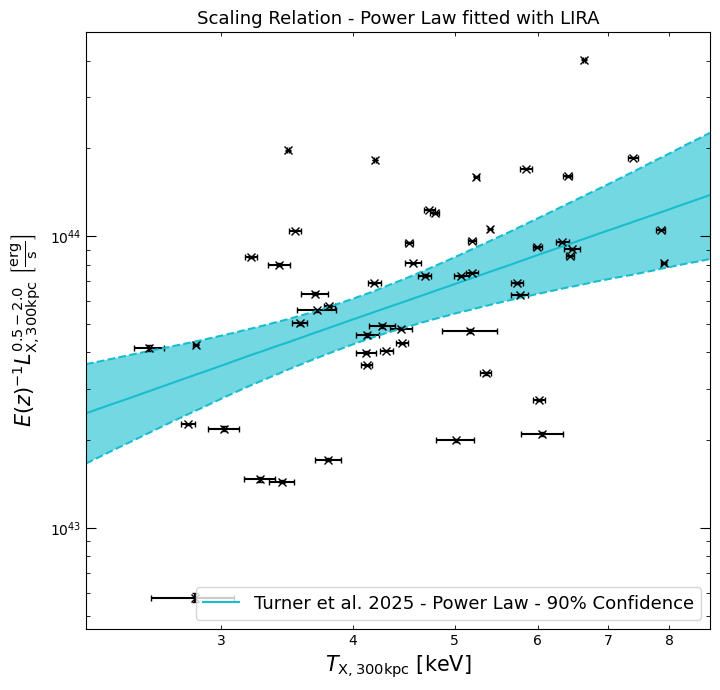

In [13]:
lx52_300kpc_tx300kpc.view(figsize=(7.3, 7), save_path=vis_path + "turner2025_lx52_tx_300kpc.pdf")

### $L^{0.5-2.0}_{\rm{X,500kpc}}$-$T_{\rm{X,500kpc}}$

In [14]:
# Setting up property variables in astropy quantity objects
lx500kpc_52 = Quantity(xlovoccs_samp[['Lx52_500kpc', 'Lx52_500kpc-','Lx52_500kpc+']].values*1e+44, 'erg/s')\
    *(xlovoccs_samp['E'].values[..., None]**(-1))
tx500kpc = Quantity(xlovoccs_samp[['Tx_500kpc', 'Tx_500kpc-','Tx_500kpc+']].values, 'keV')
    
lx52_500kpc_tx500kpc = scaling_relation_lira(lx500kpc_52[:, 0], lx500kpc_52[:, 1:], tx500kpc[:, 0], tx500kpc[:, 1:], lx_norm, tx_norm, 
                                             y_name=r"$E(z)^{-1}L^{0.5-2.0}_{\rm{X,500kpc}}$", x_name=r"$T_{\rm{X,500kpc}}$", 
                                             dim_hubb_ind=-1, point_names=xlovoccs_samp['name'].values)
lx52_500kpc_tx500kpc.model_colour = 'firebrick'
lx52_500kpc_tx500kpc.author = 'Turner et al.'
lx52_500kpc_tx500kpc.year = 2025
lx52_500kpc_tx500kpc.name = r'Turner et al. $E(z)^{-1}L^{0.5-2.0}_{\rm{X,500kpc}}$-$T_{\rm{X,500kpc}}$'
lx52_500kpc_tx500kpc.save(sr_path + "turner2025_lx52_tx_500kpc.xgarel")

/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:414: UserWarning: 13 sources have NaN values or negative uncertainties and have been excluded
  third_dim_info = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm, True, point_names,


  |**************************************************| 100%


/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:450: UserWarning: 13 sources have NaN values or negative uncertainties and have been excluded
  throw_away, sec_throw_away = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm)


In [15]:
print("{n} data points\n".format(n=len(lx52_500kpc_tx500kpc.x_data)))
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=lx52_500kpc_tx500kpc.pars[0][0], e=lx52_500kpc_tx500kpc.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=lx52_500kpc_tx500kpc.pars[1][0], e=lx52_500kpc_tx500kpc.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=lx52_500kpc_tx500kpc.scatter_par[0], e=lx52_500kpc_tx500kpc.scatter_par[1]))

54 data points

Slope of 1.133 ± 0.314

Normalisation of 0.779 ± 0.073

Scatter of 0.275 ± 0.028


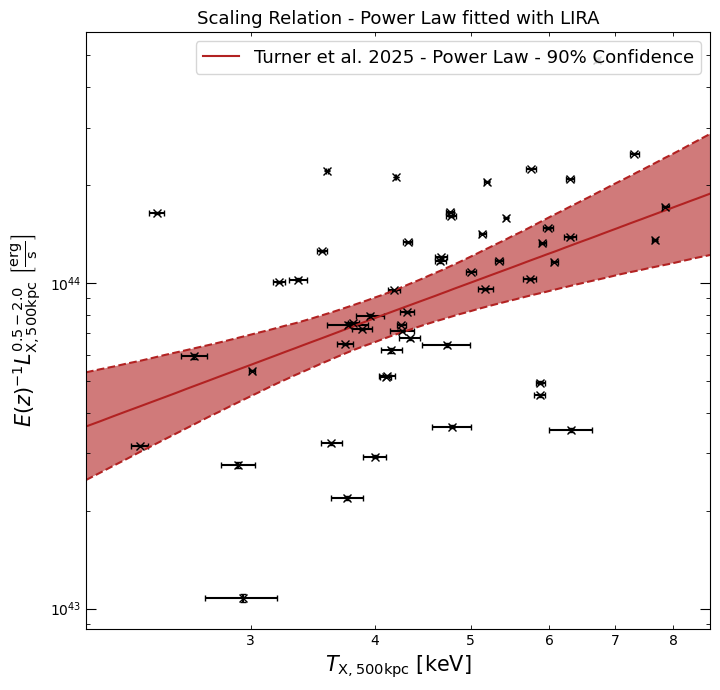

In [16]:
lx52_500kpc_tx500kpc.view(figsize=(7.3, 7), save_path=vis_path + "turner2025_lx52_tx_500kpc.pdf")

### $L^{0.5-2.0}_{\rm{X,1000kpc}}$-$T_{\rm{X,1000kpc}}$

In [17]:
# Setting up property variables in astropy quantity objects
lx1000kpc_52 = Quantity(xlovoccs_samp[['Lx52_1000kpc', 'Lx52_1000kpc-','Lx52_1000kpc+']].values*1e+44, 'erg/s')\
    *(xlovoccs_samp['E'].values[..., None]**(-1))
tx1000kpc = Quantity(xlovoccs_samp[['Tx_1000kpc', 'Tx_1000kpc-','Tx_1000kpc+']].values, 'keV')
    
lx52_1000kpc_tx1000kpc = scaling_relation_lira(lx1000kpc_52[:, 0], lx1000kpc_52[:, 1:], tx1000kpc[:, 0], tx1000kpc[:, 1:], lx_norm, 
                                               tx_norm, y_name=r"$E(z)^{-1}L^{0.5-2.0}_{\rm{X,1000kpc}}$", 
                                               x_name=r"$T_{\rm{X,1000kpc}}$", dim_hubb_ind=-1, 
                                               point_names=xlovoccs_samp['name'].values)
lx52_1000kpc_tx1000kpc.model_colour = 'darkkhaki'
lx52_1000kpc_tx1000kpc.author = 'Turner et al.'
lx52_1000kpc_tx1000kpc.year = 2025
lx52_1000kpc_tx1000kpc.name = r'Turner et al. $E(z)^{-1}L^{0.5-2.0}_{\rm{X,1000kpc}}$-$T_{\rm{X,1000kpc}}$'
lx52_1000kpc_tx1000kpc.save(sr_path + "turner2025_lx52_tx_1000kpc.xgarel")

/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:414: UserWarning: 23 sources have NaN values or negative uncertainties and have been excluded
  third_dim_info = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm, True, point_names,


  |**************************************************| 100%


/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:450: UserWarning: 23 sources have NaN values or negative uncertainties and have been excluded
  throw_away, sec_throw_away = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm)


In [18]:
print("{n} data points\n".format(n=len(lx52_1000kpc_tx1000kpc.x_data)))
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=lx52_1000kpc_tx1000kpc.pars[0][0], e=lx52_1000kpc_tx1000kpc.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=lx52_1000kpc_tx1000kpc.pars[1][0], e=lx52_1000kpc_tx1000kpc.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=lx52_1000kpc_tx1000kpc.scatter_par[0], e=lx52_1000kpc_tx1000kpc.scatter_par[1]))

44 data points

Slope of 1.092 ± 0.268

Normalisation of 1.048 ± 0.087

Scatter of 0.235 ± 0.027


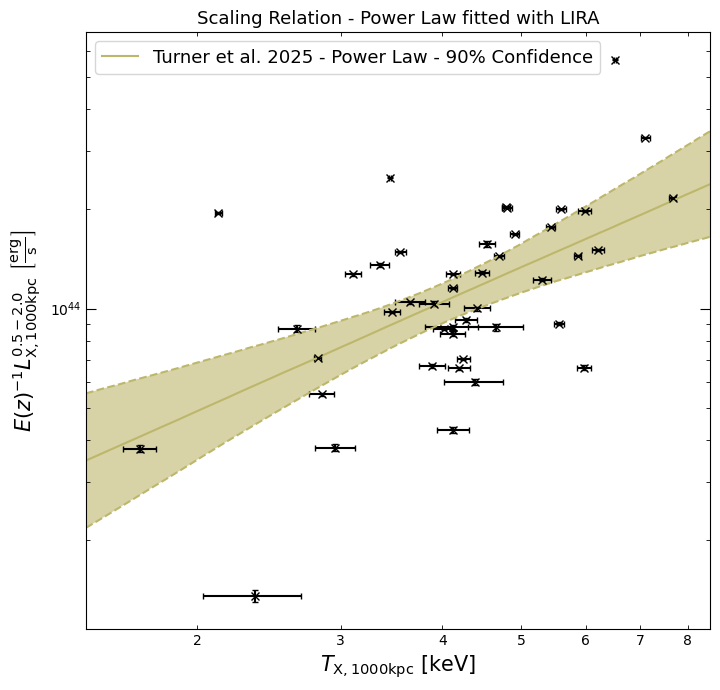

In [19]:
lx52_1000kpc_tx1000kpc.view(figsize=(7.3, 7), save_path=vis_path + "turner2025_lx52_tx_1000kpc.pdf")

### $L^{\rm{bol}}_{\rm{X,300kpc}}$-$T_{\rm{X,300kpc}}$

In [20]:
# Setting up property variables in astropy quantity objects
lx300kpc_bol = Quantity(xlovoccs_samp[['Lxbol_300kpc', 'Lxbol_300kpc-','Lxbol_300kpc+']].values*1e+44, 'erg/s')\
    *(xlovoccs_samp['E'].values[..., None]**(-1))
tx300kpc = Quantity(xlovoccs_samp[['Tx_300kpc', 'Tx_300kpc-','Tx_300kpc+']].values, 'keV')
    
lxbol_300kpc_tx300kpc = scaling_relation_lira(lx300kpc_bol[:, 0], lx300kpc_bol[:, 1:], tx300kpc[:, 0], tx300kpc[:, 1:], lx_norm, 
                                              tx_norm, y_name=r"$E(z)^{-1}L^{\rm{bol}}_{\rm{X,300kpc}}$", x_name=r"$T_{\rm{X,300kpc}}$", 
                                              dim_hubb_ind=-1, point_names=xlovoccs_samp['name'].values)
lxbol_300kpc_tx300kpc.model_colour = 'slategrey'
lxbol_300kpc_tx300kpc.author = 'Turner et al.'
lxbol_300kpc_tx300kpc.year = 2025
lxbol_300kpc_tx300kpc.name = r'Turner et al. $E(z)^{-1}L^{\rm{bol}}_{\rm{X,300kpc}}$-$T_{\rm{X,300kpc}}$'
lxbol_300kpc_tx300kpc.save(sr_path + "turner2025_lxbol_tx_300kpc.xgarel")

/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:414: UserWarning: 15 sources have NaN values or negative uncertainties and have been excluded
  third_dim_info = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm, True, point_names,


  |**************************************************| 100%


/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:450: UserWarning: 15 sources have NaN values or negative uncertainties and have been excluded
  throw_away, sec_throw_away = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm)


In [21]:
print("{n} data points\n".format(n=len(lxbol_300kpc_tx300kpc.x_data)))
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=lxbol_300kpc_tx300kpc.pars[0][0], e=lxbol_300kpc_tx300kpc.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=lxbol_300kpc_tx300kpc.pars[1][0], e=lxbol_300kpc_tx300kpc.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=lxbol_300kpc_tx300kpc.scatter_par[0], e=lxbol_300kpc_tx300kpc.scatter_par[1]))

52 data points

Slope of 1.717 ± 0.365

Normalisation of 1.533 ± 0.168

Scatter of 0.307 ± 0.032


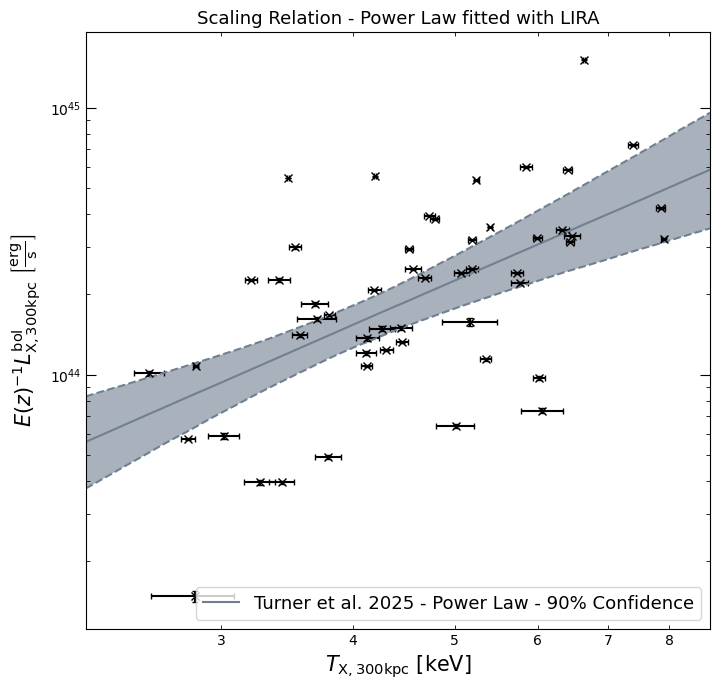

In [22]:
lxbol_300kpc_tx300kpc.view(figsize=(7.3, 7), save_path=vis_path + "turner2025_lxbol_tx_300kpc.pdf")

### $L^{\rm{bol}}_{\rm{X,500kpc}}$-$T_{\rm{X,500kpc}}$

In [23]:
# Setting up property variables in astropy quantity objects
lx500kpc_bol = Quantity(xlovoccs_samp[['Lxbol_500kpc', 'Lxbol_500kpc-','Lxbol_500kpc+']].values*1e+44, 'erg/s')\
    *(xlovoccs_samp['E'].values[..., None]**(-1))
tx500kpc = Quantity(xlovoccs_samp[['Tx_500kpc', 'Tx_500kpc-','Tx_500kpc+']].values, 'keV')
    
lxbol_500kpc_tx500kpc = scaling_relation_lira(lx500kpc_bol[:, 0], lx500kpc_bol[:, 1:], tx500kpc[:, 0], tx500kpc[:, 1:], lx_norm, 
                                              tx_norm, y_name=r"$E(z)^{-1}L^{\rm{bol}}_{\rm{X,500kpc}}$", x_name=r"$T_{\rm{X,500kpc}}$", 
                                             dim_hubb_ind=-1, point_names=xlovoccs_samp['name'].values)
lxbol_500kpc_tx500kpc.model_colour = 'darkviolet'
lxbol_500kpc_tx500kpc.author = 'Turner et al.'
lxbol_500kpc_tx500kpc.year = 2025
lxbol_500kpc_tx500kpc.name = r'Turner et al. $E(z)^{-1}L^{\rm{bol}}_{\rm{X,500kpc}}$-$T_{\rm{X,500kpc}}$'
lxbol_500kpc_tx500kpc.save(sr_path + "turner2025_lxbol_tx_500kpc.xgarel")

/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:414: UserWarning: 13 sources have NaN values or negative uncertainties and have been excluded
  third_dim_info = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm, True, point_names,


  |**************************************************| 100%


/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:450: UserWarning: 13 sources have NaN values or negative uncertainties and have been excluded
  throw_away, sec_throw_away = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm)


In [24]:
print("{n} data points\n".format(n=len(lxbol_500kpc_tx500kpc.x_data)))
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=lxbol_500kpc_tx500kpc.pars[0][0], e=lxbol_500kpc_tx500kpc.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=lxbol_500kpc_tx500kpc.pars[1][0], e=lxbol_500kpc_tx500kpc.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=lxbol_500kpc_tx500kpc.scatter_par[0], e=lxbol_500kpc_tx500kpc.scatter_par[1]))

54 data points

Slope of 1.574 ± 0.317

Normalisation of 2.309 ± 0.218

Scatter of 0.276 ± 0.028


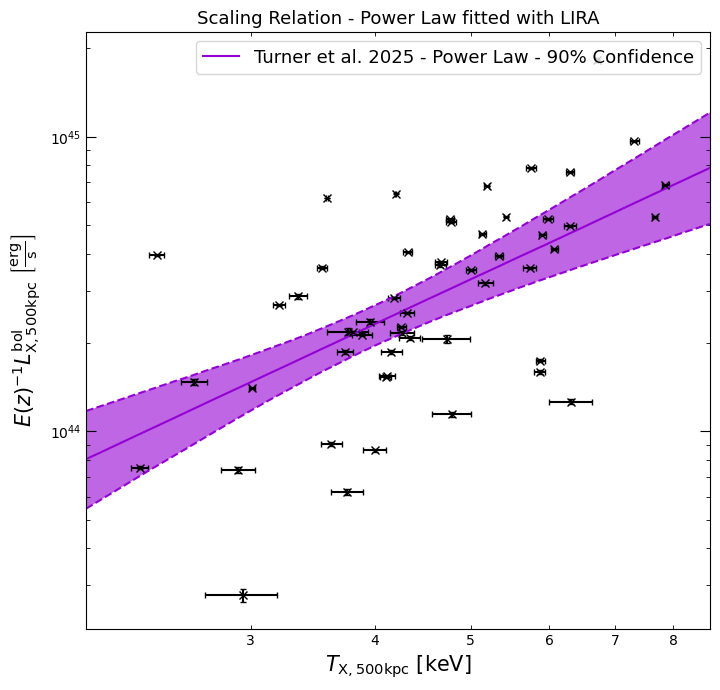

In [25]:
lxbol_500kpc_tx500kpc.view(figsize=(7.3, 7), save_path=vis_path + "turner2025_lxbol_tx_500kpc.pdf")

### $L^{\rm{bol}}_{\rm{X,1000kpc}}$-$T_{\rm{X,1000kpc}}$

In [30]:
# Setting up property variables in astropy quantity objects
lx1000kpc_bol = Quantity(xlovoccs_samp[['Lxbol_1000kpc', 'Lxbol_1000kpc-','Lxbol_1000kpc+']].values*1e+44, 'erg/s')\
    *(xlovoccs_samp['E'].values[..., None]**(-1))
tx1000kpc = Quantity(xlovoccs_samp[['Tx_1000kpc', 'Tx_1000kpc-','Tx_1000kpc+']].values, 'keV')
    
lxbol_1000kpc_tx1000kpc = scaling_relation_lira(lx1000kpc_bol[:, 0], lx1000kpc_bol[:, 1:], tx1000kpc[:, 0], tx1000kpc[:, 1:], 
                                                lx_norm, tx_norm, y_name=r"$E(z)^{-1}L^{\rm{bol}}_{\rm{X,1000kpc}}$", 
                                                x_name=r"$T_{\rm{X,1000kpc}}$", dim_hubb_ind=-1, 
                                                point_names=xlovoccs_samp['name'].values)
lxbol_1000kpc_tx1000kpc.model_colour = 'wheat'
lxbol_1000kpc_tx1000kpc.author = 'Turner et al.'
lxbol_1000kpc_tx1000kpc.year = 2025
lxbol_1000kpc_tx1000kpc.name = r'Turner et al. $E(z)^{-1}L^{\rm{bol}}_{\rm{X,1000kpc}}$-$T_{\rm{X,1000kpc}}$'
lxbol_1000kpc_tx1000kpc.save(sr_path + "turner2025_lxbol_tx_1000kpc.xgarel")

/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:414: UserWarning: 23 sources have NaN values or negative uncertainties and have been excluded
  third_dim_info = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm, True, point_names,


  |**************************************************| 100%


/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/relations/fit.py:450: UserWarning: 23 sources have NaN values or negative uncertainties and have been excluded
  throw_away, sec_throw_away = _fit_initialise(y_values, y_errs, x_values, x_errs, y_norm, x_norm)


In [31]:
print("{n} data points\n".format(n=len(lxbol_1000kpc_tx1000kpc.x_data)))
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=lxbol_1000kpc_tx1000kpc.pars[0][0], e=lxbol_1000kpc_tx1000kpc.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=lxbol_1000kpc_tx1000kpc.pars[1][0], e=lxbol_1000kpc_tx1000kpc.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=lxbol_1000kpc_tx1000kpc.scatter_par[0], e=lxbol_1000kpc_tx1000kpc.scatter_par[1]))

44 data points

Slope of 1.512 ± 0.268

Normalisation of 3.121 ± 0.261

Scatter of 0.235 ± 0.027


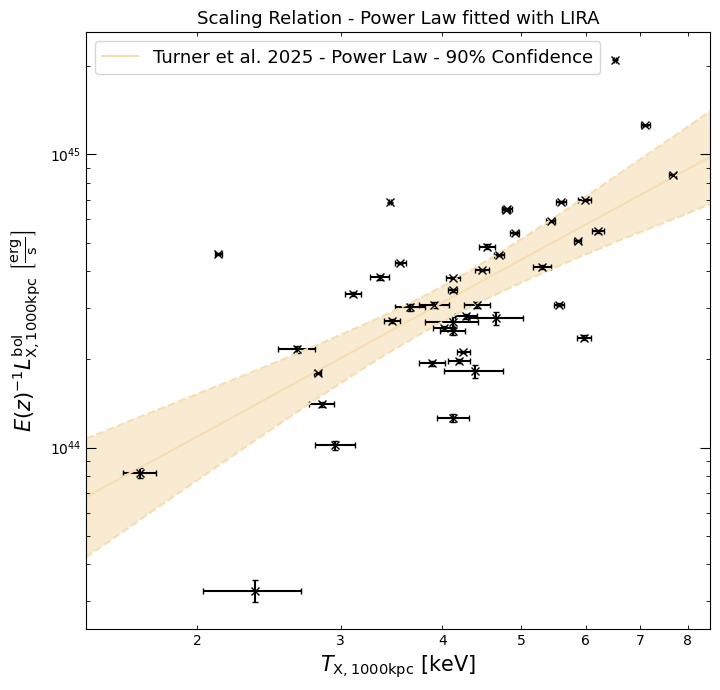

In [32]:
lxbol_1000kpc_tx1000kpc.view(figsize=(7.3, 7), save_path=vis_path + "turner2025_lxbol_tx_1000kpc.pdf")

### Combined contours

/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/products/relation.py:1305: UserWarning: Not all of these ScalingRelations have the same x-axis names.
  warn('Not all of these ScalingRelations have the same x-axis names.')
/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/products/relation.py:1312: UserWarning: Not all of these ScalingRelations have the same y-axis names.
  warn('Not all of these ScalingRelations have the same y-axis names.')


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


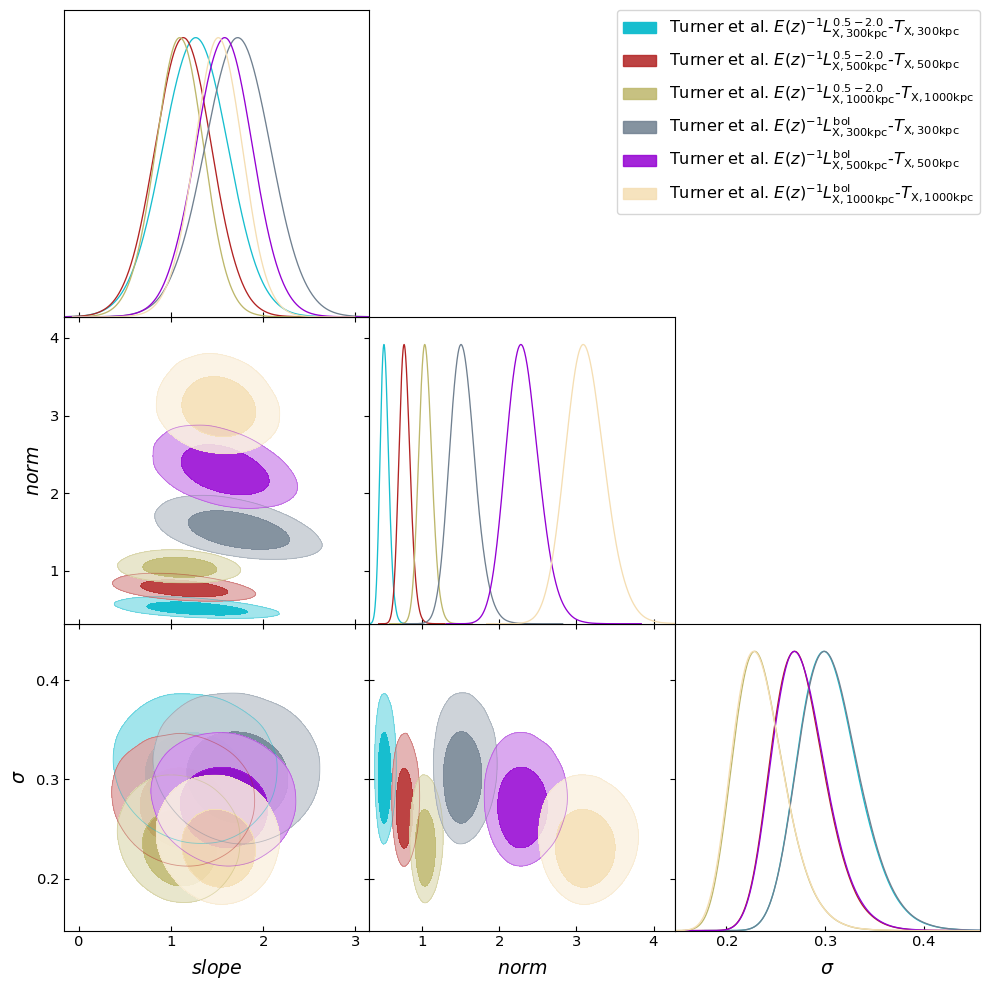

In [33]:
comb_rel = (lx52_300kpc_tx300kpc + lx52_500kpc_tx500kpc + lx52_1000kpc_tx1000kpc + 
            lxbol_300kpc_tx300kpc + lxbol_500kpc_tx500kpc + lxbol_1000kpc_tx1000kpc)
comb_rel.view_corner(save_path=vis_path + "turner2025_mgas_lx_contours.pdf")